# Swift UVOT Events

## Reading in Data

In [109]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import Angle, SkyCoord
from astropy.stats import sigma_clipped_stats
from astropy.timeseries import TimeSeries
from astropy.timeseries import LombScargle
from astropy.timeseries import BoxLeastSquares
from astropy import units as u
from astropy.time import Time
from astropy.time import TimeGPS

from regions import CircleSkyRegion
from scipy.optimize import curve_fit
from photutils.detection import DAOStarFinder

import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
%matplotlib inline
import numpy as np

In [3]:
eventFile = fits.open('/home/saphio/sw00094137009um2w1po_uf.evt.gz')
imgFile = fits.open('/home/saphio/sw00094137009u_sk.img.gz')

primaryHdu = imgFile[0]
imgHdu = imgFile[1]

wcs = WCS(imgHdu.header)

events = eventFile[1].data

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 59236.264051 from DATE-OBS.
Set MJD-END to 59236.548553 from DATE-END'. [astropy.wcs.wcs]


In [4]:
primaryHdu.header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
TELESCOP= 'SWIFT   '           / Telescope (mission) name                       
INSTRUME= 'UVOTA   '           / Instrument name                                
DETNAM  = '800     '                                                            
OBS_ID  = '00094137009'        / Observation ID                                 
TARG_ID =                94137 / Target ID                                      
SEG_NUM =                    9 / Segment number                                 
TIMESYS = 'TT      '        

In [5]:
events

FITS_rec([(6.32983520e+08,   1867,   1370, 1916, 1439, 2238, 1547, 1,   0),
          (6.32983520e+08,   1534,   1402, 1593, 1476, 2137, 1857, 1,   0),
          (6.32983520e+08,   2039,   1420, 2079, 1486, 2348, 1419, 1,   0),
          ...,
          (6.33013801e+08,   1164,   1636, 1229, 1718, 2616, 2093, 6, 256),
          (6.33013801e+08,    347,   1727,  432, 1810, 2294, 2827, 6, 256),
          (6.33013801e+08,   1453,   1997, 1503, 2069, 3058, 2034, 6, 256)],
         dtype=(numpy.record, [('TIME', '>f8'), ('RAWX', '>i2'), ('RAWY', '>i2'), ('DETX', '>i2'), ('DETY', '>i2'), ('X', '>i2'), ('Y', '>i2'), ('EXPREF', '>i2'), ('QUALITY', '>i2')]))

In [6]:
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 116.110733 3.551811 
CRPIX : 1604.5 1583.5 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.000139444442 0.000139444442 
NAXIS : 3208  3166

## Cleaning Event Data

In [7]:
events_clean = events[np.where((events.QUALITY == 0))]
## quality flag of 0 = good
print(f'removed {len(events) - len(events_clean)} events')

removed 1952995 events


In [8]:
max(events_clean['RAWX'])

2047

## Displaying Event Data

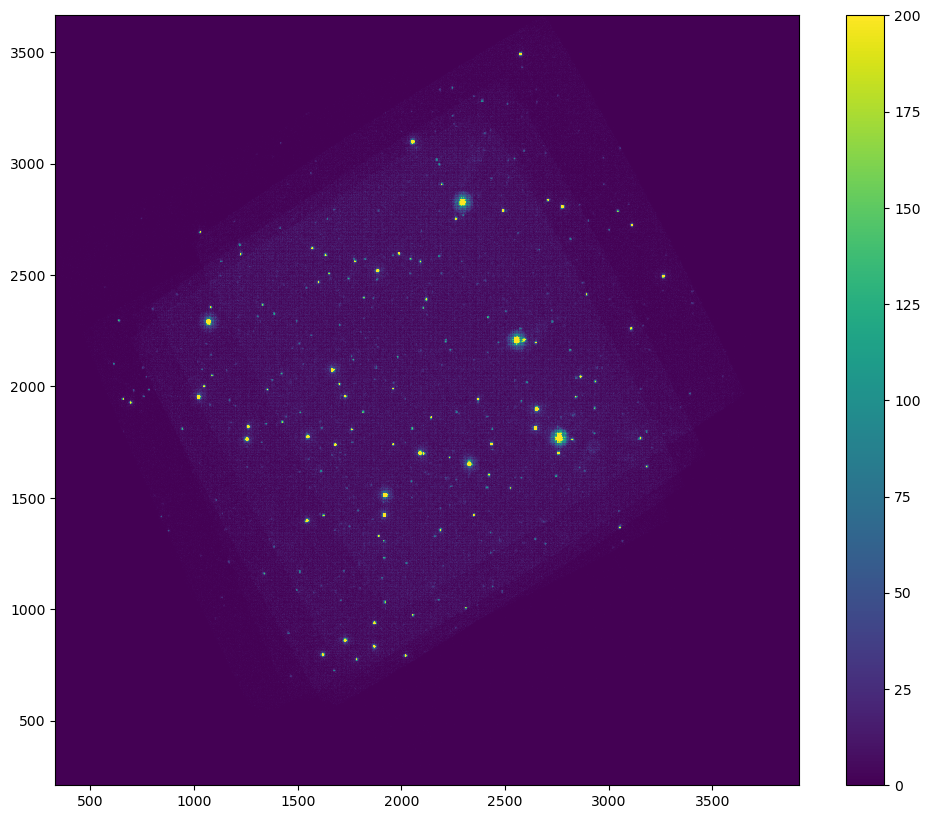

In [141]:
fig, ax = plt.subplots(figsize=(12, 10))

#plt.subplot(projection=wcs)

histdata, x_bins, y_bins, img = plt.hist2d(events_clean.X, events_clean.Y, bins=1000, vmin=0, vmax=200)
plt.colorbar()

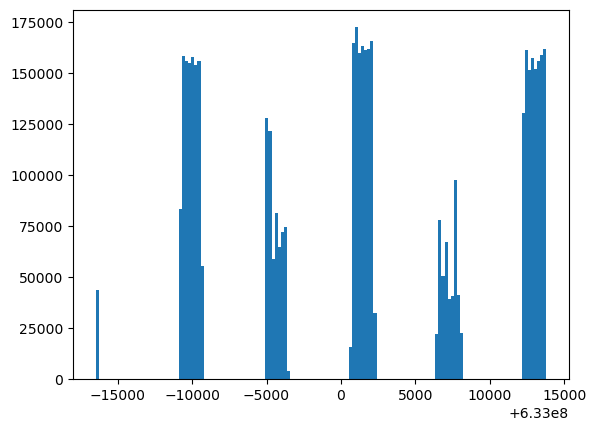

In [10]:
times = plt.hist(events_clean['TIME'], bins='auto')

In [11]:
## selecting a time period with continuous data

def evtInterval(tStart, tStop, evtList):
    interval = evtList [np.where((evtList.TIME > tStart) &
                                 (evtList.TIME < tStop))]
    
    return interval

## Practicing Making Images of Intervals

In [37]:
interval0 = evtInterval(632980000, 632985000, events_clean)
interval1 = evtInterval(632985000, 632992500, events_clean)
interval2 = evtInterval(632992500, 633000000, events_clean)
interval3 = evtInterval(633000000, 633003000, events_clean)
interval4 = evtInterval(633005000, 633010000, events_clean)
interval5 = evtInterval(633010000, 633015000, events_clean)

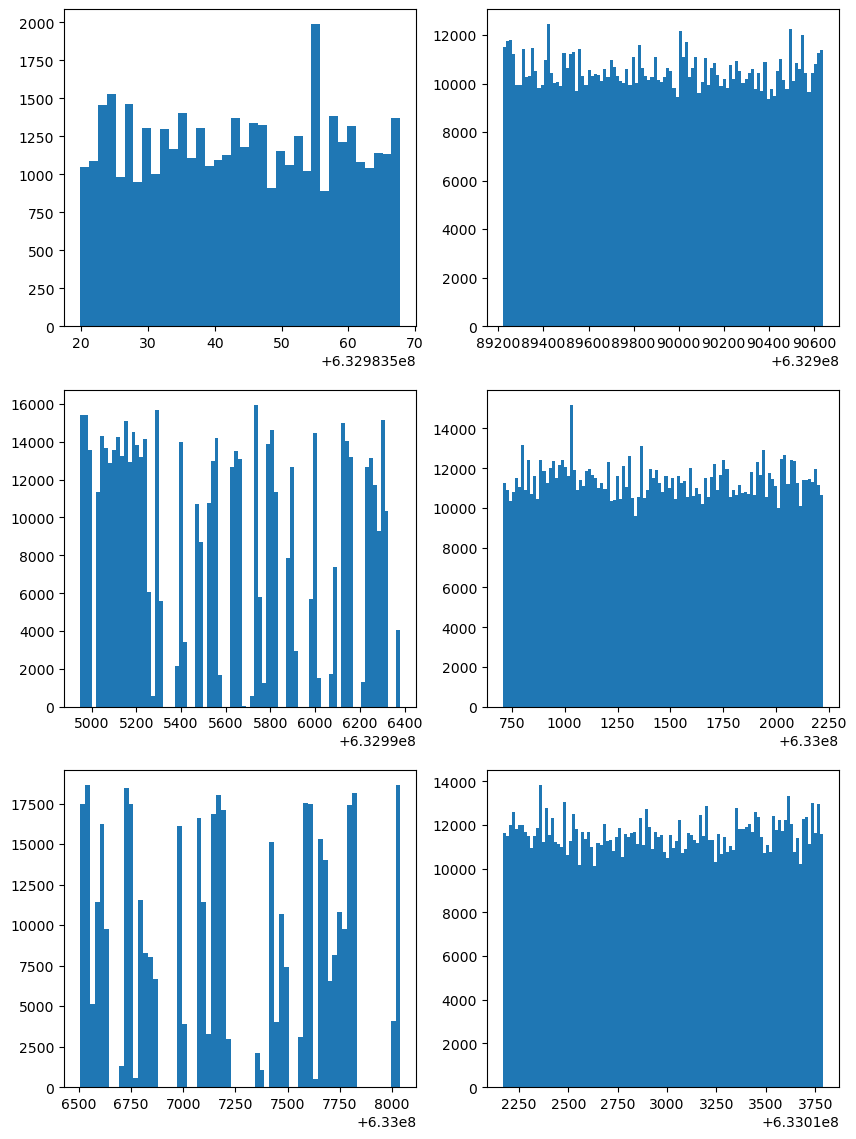

In [38]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 14))
_ = axes[0][0].hist(interval0['TIME'], bins='auto')
_ = axes[0][1].hist(interval1['TIME'], bins='auto')
_ = axes[1][0].hist(interval2['TIME'], bins='auto')
_ = axes[1][1].hist(interval3['TIME'], bins='auto')
_ = axes[2][0].hist(interval4['TIME'], bins='auto')
_ = axes[2][1].hist(interval5['TIME'], bins='auto')

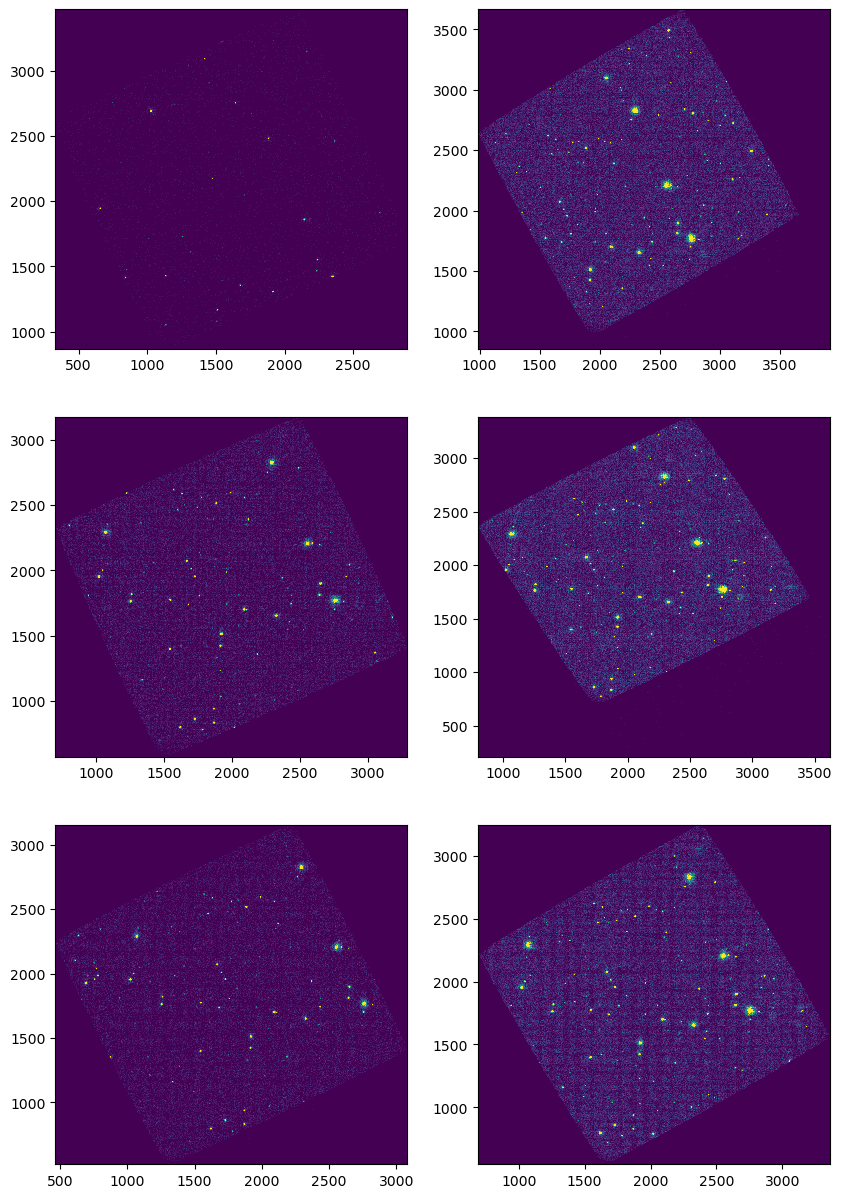

In [43]:
## visualization

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))

histdata, x, y, img = axes[0][0].hist2d(interval0.X, interval0.Y, bins=1000, vmin=0, vmax = 20)
histdata, x, y, img = axes[0][1].hist2d(interval1.X, interval1.Y, bins=1000, vmin=0, vmax = 20)
histdata, x, y, img = axes[1][0].hist2d(interval2.X, interval2.Y, bins=1000, vmin=0, vmax = 20)
histdata, x, y, img = axes[1][1].hist2d(interval3.X, interval3.Y, bins=1000, vmin=0, vmax = 20)
histdata, x, y, img = axes[2][0].hist2d(interval4.X, interval4.Y, bins=1000, vmin=0, vmax = 20)
histdata, x, y, img = axes[2][1].hist2d(interval5.X, interval5.Y, bins=1000, vmin=0, vmax = 20)

## Star-finding

### Using counting_stars_v5 

In [12]:
## import annulus
from PIL import Image
im_frame = Image.open('/home/saphio/repo/counting_stars/annuli_imgs/annulus_22.png')

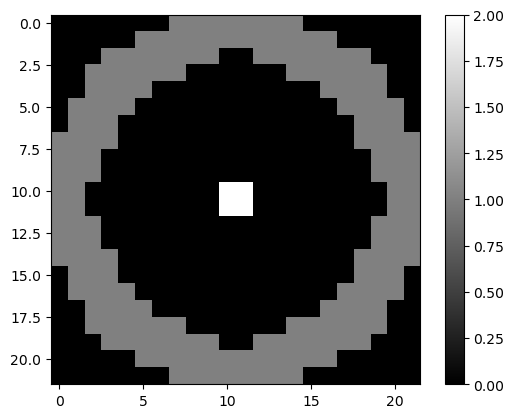

In [13]:
np_frame = np.array(im_frame)
annulus_size = len(np_frame)

## fix up imported annulus
annulus = np.zeros((annulus_size, annulus_size))
for i in range(annulus_size):
    for j in range(annulus_size):
        if (np_frame[i, j, 0] == 0 and np_frame[i, j, 3] == 255):
            annulus[i, j] = 1 ## background
        elif (np_frame[i, j, 0] == 112):
            annulus[i, j] = 2 ## star (circle aperture)
            
plt.imshow(annulus, cmap='gray')
plt.colorbar()

In [14]:
flatImg = histdata

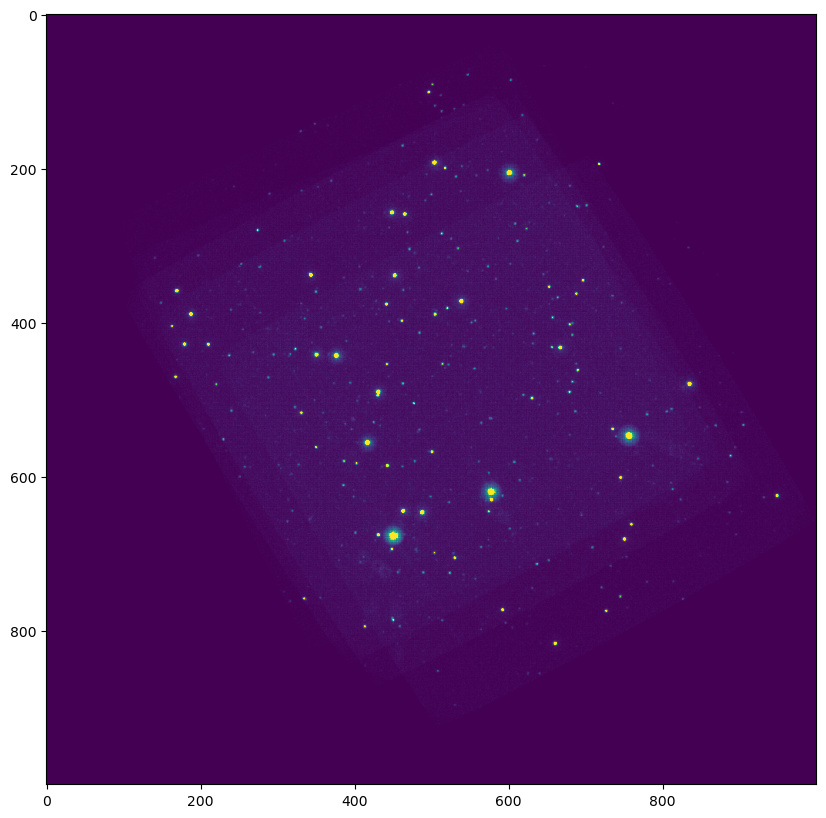

In [15]:
plt.figure(figsize=(10, 10))
plt.imshow(flatImg, vmin=0, vmax=200)

In [16]:
## signal-to-noise ratio function from counting_stars_v5

def calculate_ratio (testImg, x, y):
    ## Summing counts

    circle_counts = 0
    annulus_counts = 0
    
    circle_pixels = 0
    annulus_pixels = 0

    for i in range(annulus_size):
        for j in range(annulus_size):
            try:
                if (annulus[i, j] == 2):
                    circle_counts += testImg[i + x, j + y]
                    circle_pixels += 1
                elif (annulus[i, j] == 1):
                    annulus_counts += testImg[i + x, j + y]
                    annulus_pixels += 1
            except:
                pass
                
    # Sky background per Pixel (N_s)
    sky_bg_pixel = annulus_counts / annulus_pixels

    # Signal in Aperture (N_T)
    signal = (circle_counts - (circle_pixels * annulus_counts / annulus_pixels))
    
    # Total noise = sqrt(N_T + N_s * npix + other stuff (dark current, readout))
    total_noise = np.sqrt(signal + (circle_pixels * annulus_counts / annulus_pixels))
    
    if (total_noise == 0):
        total_noise = 0.01
    
    return signal/total_noise

(1000, 1000)

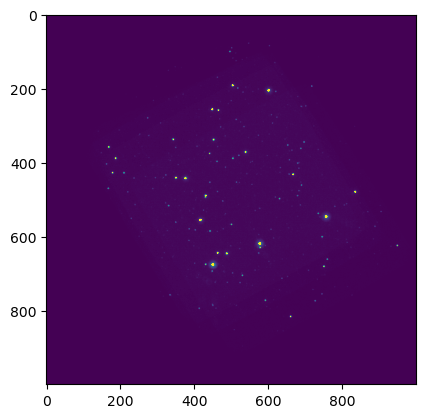

In [17]:
testImg = flatImg
plt.imshow(testImg, vmin=0, vmax=500)
testImg.shape

In [18]:
snrImg = np.zeros(testImg.shape)
offset = int((annulus_size + 1)/2)
for i in range(-offset, len(testImg) - offset):
    for j in range(-offset, len(testImg[0]) - offset):
        snrImg[i + offset, j + offset] = calculate_ratio(testImg, i, j)

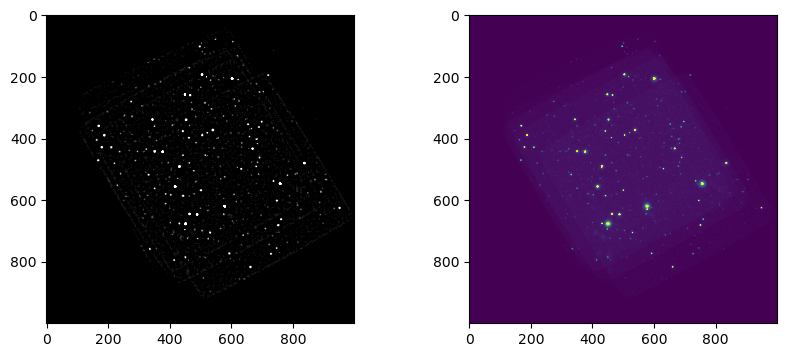

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].imshow(snrImg, cmap='gray', vmin=0, vmax=15)
axes[1].imshow(testImg, vmin=0, vmax=200)

In [20]:
snrData = snrImg.flatten()

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

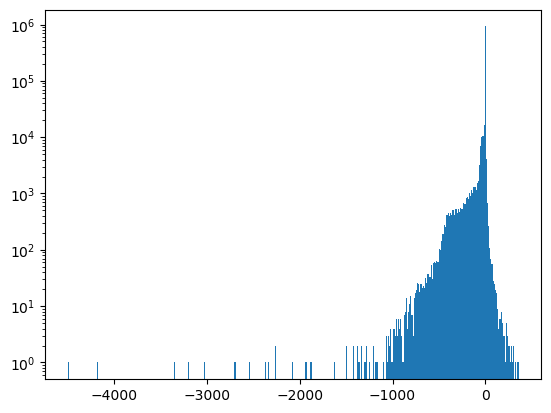

In [21]:
## histogram

n, bins, _ = plt.hist(snrData, bins=400, log=True)

## fitting gaussian curve
def gaussian (x, a, mean, sigma):
    return a * np.exp(-((x-mean)**2)/(2*sigma**2))

x = np.linspace(min(snrData), max(snrData), 400)
y = n

popt, pcov = curve_fit(gaussian, x, y)
plt.plot(x, gaussian(x, *popt), c='r')

plt.axis([min(snrData) - 10, max(snrData) + 10, 0.5, 50000])

## fit parameters
print('amp', popt[0], '\nmean', popt[1], '\nsigma', popt[2])
amp, mean, stdev = popt

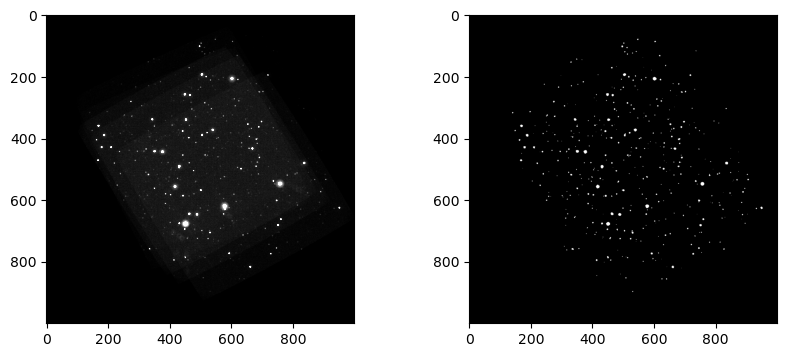

In [32]:
#threshold = mean + 5 * stdev
threshold = 5

## apply threshold on testImg
imgCut = np.zeros(snrImg.shape)

for i in range(len(snrImg)):
    for j in range(len(snrImg[0])):
        if (snrImg[i, j] >= threshold):
            imgCut[i, j] = 100
        else:
            imgCut[i, j] = 0

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
axes[0].imshow(testImg, cmap='gray', vmin=0, vmax=100)
axes[1].imshow(imgCut, cmap='gray')

In [33]:
## counting the stars

def hasNeighborAbove (matrix, i, j):
    try:
        if (matrix[i - 1][j - 2] or
            matrix[i - 1][j - 1] or
            matrix[i - 1][j] or
            matrix[i - 1][j + 1] or
            matrix[i - 1][j + 2] or
            matrix[i][j - 1]):
            return 0
        else:
            return 1
    except:
        return -1

In [34]:
matrix = [[False for i in range(len(testImg[0]))] for j in range(len(testImg))]

count = 0

for i in range(len(imgCut)):
    for j in range(len(imgCut[0])):
        if (imgCut[i, j] == 100):
            matrix[i][j] = True
            if (hasNeighborAbove(matrix, i, j) == 1):
                count += 1
        else:
            matrix[i][j] = False

In [35]:
count

421

### Using DAOFinder

In [36]:
mean_bg, median_bg, bg_sd = sigma_clipped_stats(testImg, sigma=3.0)

daofind = DAOStarFinder(fwhm=8.0, threshold=2.75*bg_sd)

srcs = daofind(testImg - median_bg)

srcs

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,574.9002340832405,119.06645691708191,0.6062237099341858,-0.3096269827668431,-0.7490793644086488,121,0.0,8.0,1.0788431611511053,-0.08239578224133298
2,514.1081635521763,135.2020617743686,0.2353923685461549,-0.46682757132934943,-0.3832789938772021,121,0.0,5.0,1.3675066025352423,-0.3398235796301244
3,365.41464621566934,144.13578628733723,0.7512094345575161,0.07810923862023057,-0.00395128680658983,121,0.0,9.0,1.8330697775190652,-0.6579474927583904
4,606.0702854787065,152.67315345477252,0.3217378142417049,0.585299173190773,0.05315010497290713,121,0.0,9.0,1.0243275860585908,-0.026097172034006424
5,505.5243017678662,154.30210196987224,0.8895736995350969,-0.04151422900153006,0.32193171859086567,121,0.0,11.0,1.1918385481463543,-0.19054356972248973
6,568.3936989160479,160.44477994240415,0.9055718462340266,-0.35901463075365736,-0.34711641151040934,121,0.0,13.0,1.2384910536351055,-0.2322321844081116
...,...,...,...,...,...,...,...,...,...,...
366,581.2635834049842,793.358626164909,0.20696924031439637,-0.6974859190569604,-0.0957548254433312,121,0.0,5.0,1.1356206663641144,-0.13808321836611803
367,642.1788558246514,816.2864373333689,0.6266282752124552,0.25706625830550917,0.07004443307591797,121,0.0,7.0,1.3046417019891206,-0.2887281408438824


In [37]:
x_coords = np.array(srcs['xcentroid'])
y_coords = np.array(srcs['ycentroid'])

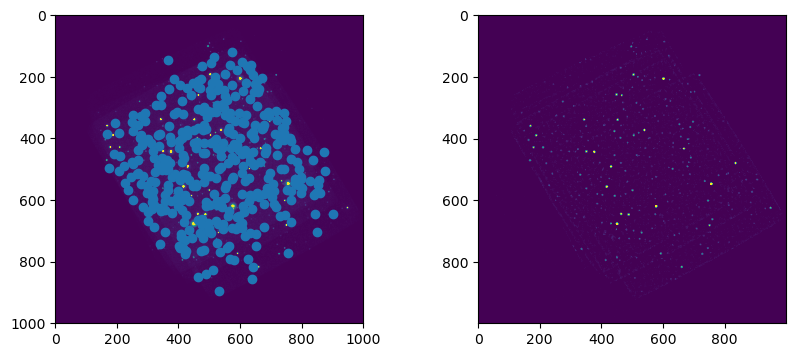

In [80]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

axes[0].imshow(testImg, vmin=0, vmax=200)
axes[0].scatter(x_coords, y_coords)
axes[0].set_xlim(0, 1000)
axes[0].set_ylim(1000, 0)

axes[1].imshow(snrImg, vmin=0, vmax=40)

## missed some of the larger stars + fainter stars
## need to actually calculate FWHM as 8 is arbitrary

## Finding the Changing Event

### Isolating Stars

In [39]:
def getStar (matrix, i, j):
    ## initial star has coords (i, j)
    star = []
    queue = [[i, j]]
    visited = []
    
    ## floodfill to get the rest of the star
    while (queue != []):
        n1, n2 = queue.pop(0)
        if (matrix[n1][n2] and [n1, n2] not in visited):
            star.append([n1, n2])
            if (n1 > 0 and [n1 - 1, n2] not in visited):
                queue.append([n1 - 1, n2])
            if (n1 < len(matrix) - 2 and [n1 + 1, n2] not in visited):
                queue.append([n1 + 1, n2])
            if (n2 > 0 and [n1, n2 - 1] not in visited):
                queue.append([n1, n2 - 1])
            if (n2 < len(matrix[0]) - 2 and [n1, n2 + 1] not in visited):
                queue.append([n1, n2 + 1])
        
        visited.append([n1, n2])
        
    return [star, visited]

In [40]:
stars = []
visited = []
for i in range(1, len(matrix)):
    for j in range(1, len(matrix[0])):
        if (matrix[i][j] and [i, j] not in visited):
            [star, v] = getStar(matrix, i, j)
            stars.append(star)
            visited += v

### Mapping from bins to X, Y

In [71]:
star1, star2

([[470, 288],
  [471, 288],
  [470, 289],
  [472, 288],
  [471, 287],
  [471, 289],
  [473, 288],
  [472, 287],
  [472, 289],
  [471, 290],
  [474, 288],
  [473, 287],
  [473, 289],
  [472, 290],
  [474, 289],
  [473, 290]],
 [[604, 614],
  [605, 614],
  [604, 615],
  [606, 614],
  [605, 615],
  [604, 616],
  [607, 614],
  [606, 615],
  [605, 616],
  [604, 617],
  [607, 615],
  [606, 616],
  [605, 617],
  [607, 616],
  [606, 617]])

By accident, isolating stars this way changed the x and y coordinates, so now I need to map it back

In [93]:
def getData (star):
    starData = []
    for [s1, s2] in star:
        mask1 = events_clean['X'] >= x_bins[s1]
        filter1 = events_clean[mask1]
        mask2 = filter1['X'] < x_bins[s1 + 1]
        filter2 = filter1[mask2]
        mask3 = filter2['Y'] >= y_bins[s2]
        filter3 = filter2[mask3]
        mask4 = filter3['Y'] < y_bins[s2 + 1]
        filter4 = filter3[mask4]
        
        starData.append(np.array(filter4))
        
    return np.array([d for ls in starData for d in ls])

In [140]:
star = stars[3]
star

[[99, 496],
 [100, 496],
 [99, 497],
 [101, 496],
 [100, 495],
 [100, 497],
 [99, 498],
 [102, 496],
 [101, 495],
 [101, 497],
 [100, 498],
 [103, 496],
 [102, 495],
 [102, 497],
 [101, 498],
 [100, 499],
 [104, 496],
 [103, 495],
 [103, 497],
 [102, 498],
 [101, 499],
 [104, 497],
 [103, 498],
 [102, 499],
 [101, 500],
 [104, 498],
 [103, 499]]

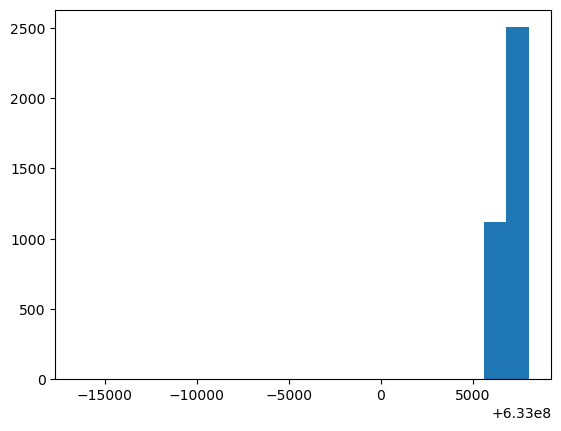

In [136]:
star_data = getData(star)
_ = plt.hist(star_data['TIME'], bins=20)

## Time Series and LS Periodogram

In [129]:
def splitData (data, d):
    data.sort()
    times = data['TIME']
    curTime = times[0]
    splits = [0]
    timeSplits = [times[0]]
    for i in range(len(times)):
        if (curTime + d >= times[i]):
            splits[-1] += 1
        else:
            splits.append(1)
            curTime = times[i]
            timeSplits.append(times[i])
    return [splits, timeSplits]

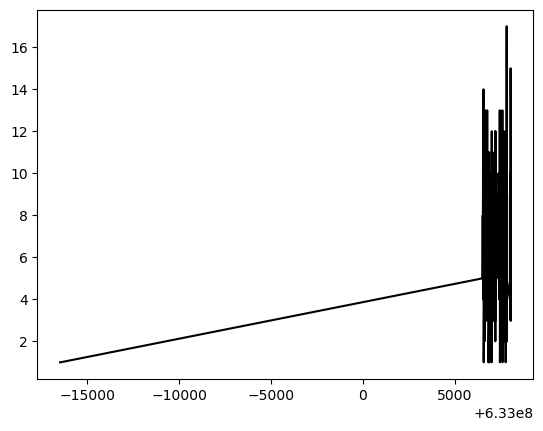

In [139]:
splits = splitData(star_data, 1)
time_splits = [Time(i, format='gps') for i in splits[1]]
ts = TimeSeries(time=time_splits)
ts['num_photons_1'] = splits[0]
plt.plot(ts.time.gps, ts['num_photons_1'], 'k-')

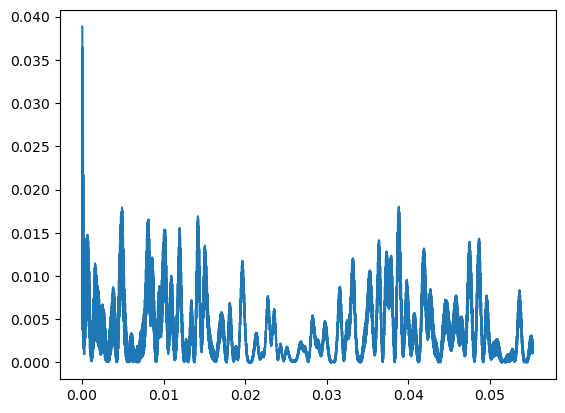

In [143]:
frequency, power = LombScargle(ts.time.gps, ts['num_photons_1']).autopower()
plt.plot(frequency, power)